# Machine Vibration Anomaly Detection (Autoencoder)

**Goal.** Detect early signs of mechanical faults from 3‑axis accelerometer vibration signals using an autoencoder trained on **normal** data.

**Dataset.** 10‑second windows @ 2 kHz (20,000 samples) per file, with labels inferred from folder names (e.g., `good/`, `bad/`).


# Setup & Paths


In [41]:
from google.colab import drive
drive.mount('/content/drive')

dataset_path = "/content/drive/My Drive/Vibration_Data_Anomaly_Detection"
samplerate = 2000


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [42]:
import pandas as pd
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import os

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from keras.models import Model, Sequential
from keras.layers import Input, Dense
from keras.optimizers import Adam

%matplotlib inline

np.random.seed(42)

# Discover Data Files

In [43]:
import pandas as pd
from glob import glob
import os, numpy as np

pattern = os.path.join(dataset_path, '*', '*', '*', '*.csv')
lens = []

for p in glob(pattern):
    try:
        df = pd.read_csv(p, nrows=100000, low_memory=False)
        num = df.apply(pd.to_numeric, errors='coerce')  # coerce mixed to numeric
        # keep rows where at least one numeric column is present
        num = num.dropna(how='all', axis=1)  # drop all-NaN cols
        lens.append(len(num))
    except Exception:
        pass

print("files counted:", len(lens))
if lens:
    print("min:", np.min(lens), "median:", int(np.median(lens)), "max:", np.max(lens))


files counted: 1372
min: 26793 median: 75776 max: 100000


In [44]:
import warnings
warnings.simplefilter(action='ignore', category=pd.errors.DtypeWarning)

data = []
labels = []

pattern = os.path.join(dataset_path, '*', '*', '*', '*.csv')

S = 10 * samplerate

for csv_file in tqdm(glob(pattern)):
    label = csv_file.split(os.sep)[-2].lower()

    # read, coerce to numeric, drop empty columns
    df  = pd.read_csv(csv_file, header=None, engine="c", low_memory=False, on_bad_lines="skip")
    num = df.apply(pd.to_numeric, errors='coerce').dropna(how='all', axis=1)

    # need at least 3 numeric columns (3 axes)
    if num.shape[1] < 3:
        continue

    # take the first 3 numeric columns as X,Y,Z
    arr = num.iloc[:, :3].dropna().to_numpy(dtype=np.float32)

    # need full 10 seconds
    if len(arr) < S:
        continue

    # keep exactly first 10s
    arr_10s = arr[:S, :]
    data.append(arr_10s)
    labels.append(0 if label == 'bad' else 1)

data = np.array(data, dtype=np.float32)
labels = np.array(labels, dtype=np.int64)

print("Data shape:", data.shape)
print("Labels shape:", labels.shape)
print("Class balance:", {int(c): int((labels==c).sum()) for c in np.unique(labels)})


100%|██████████| 1372/1372 [04:34<00:00,  4.99it/s]


Data shape: (1372, 20000, 3)
Labels shape: (1372,)
Class balance: {0: 59, 1: 1313}


# Downsample (20000 to 2000 per axis)

To reduce dimensionality and emphasize broader frequency content, I downsample time by a factor of 10.
Reshape to `(samples, 2000, 10, axes)` and average along the 10-sample blocks, yielding `(samples, 2000, 3)`.


In [45]:
downsample_factor = 10

assert data.shape[1] % downsample_factor == 0, "time length not divisible by downsample_factor"

new_shape = (
    data.shape[0],
    data.shape[1] // downsample_factor,
    downsample_factor,
    data.shape[2]
)

# average every 10 consecutive points along time axis
data_sampled = np.mean(data.reshape(new_shape), axis=2).astype(np.float32)

print("Original shape:", data.shape)
print("Downsampled shape:", data_sampled.shape)


Original shape: (1372, 20000, 3)
Downsampled shape: (1372, 2000, 3)


# Normalize per Sample (Min–Max) and Flatten

Each sample is scaled to `[0, 1]` independently to stabilize training and remove unit dependence.
After normalization, I flatten `(time × axes)` into a single feature vector for the dense autoencoder.


In [46]:
def normalize_data(data):
    """Scale each sample between 0 and 1 (min-max per sample)."""
    min_values = np.min(data, axis=1, keepdims=True)  # shape: (samples, 1, 3)
    max_values = np.max(data, axis=1, keepdims=True)  # shape: (samples, 1, 3)
    scaled_data = (data - min_values) / (max_values - min_values + 1e-11)
    return scaled_data

# Apply normalization
data_normalized = normalize_data(data_sampled)

# Flatten from (samples, time, axes) to (samples, time*axes)
data_normalized = data_normalized.reshape(data_normalized.shape[0], -1).astype(np.float32)

print("After normalization:", data_normalized.shape)

After normalization: (1372, 6000)


# Train/Validation Split (Stratified 80/20)

For anomaly detection, the autoencoder is trained **only on normal (good)** samples and validated on normal samples.


In [47]:
from sklearn.model_selection import train_test_split

# 80/20 split
X_train, X_valid, y_train, y_valid = train_test_split(
    data_normalized,
    labels,
    test_size=0.2,
    shuffle=True,
    random_state=42,
    stratify=labels
)

print(f'X_train shape: {X_train.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'X_valid shape: {X_valid.shape}')
print(f'y_valid shape: {y_valid.shape}')

# For autoencoder training: only GOOD samples (label==1)
X_train_good = X_train[y_train == 1]
X_valid_good = X_valid[y_valid == 1]
X_valid_bad  = X_valid[y_valid == 0]   # for evaluation

print("Train GOOD:", X_train_good.shape,
      "| Valid GOOD:", X_valid_good.shape,
      "| Valid BAD:", X_valid_bad.shape)


X_train shape: (1097, 6000)
y_train shape: (1097,)
X_valid shape: (275, 6000)
y_valid shape: (275,)
Train GOOD: (1050, 6000) | Valid GOOD: (263, 6000) | Valid BAD: (12, 6000)


# Autoencoder Architecture (Dense Encoder–Decoder)

The encoder compresses the input to a low-dimensional representation; the decoder reconstructs the original input.
I used ReLU activations internally and a `sigmoid` output to match `[0, 1]` normalization. Loss: Mean Absolute Error (MAE).


In [48]:
class AutoEncoder(Model):
    def __init__(self, input_dim):
        super(AutoEncoder, self).__init__()
        self.input_layer = Input(shape=(input_dim,))

        # Encoder
        self.encoder = Sequential([
            Dense(128, activation='relu', name='encoder1'),
            Dense(64,  activation='relu', name='encoder2'),
            Dense(32,  activation='relu', name='encoder3'),
        ], name='encoder')

        # Decoder
        self.decoder = Sequential([
            Dense(32,             activation='relu',    name='decoder1'),
            Dense(64,             activation='relu',    name='decoder2'),
            Dense(128,            activation='relu',    name='decoder3'),
            Dense(input_dim,      activation='sigmoid', name='output'),
        ], name='decoder')

    def call(self, inputs):
        z = self.encoder(inputs)
        return self.decoder(z)

input_dim = X_train.shape[1]
autoencoder = AutoEncoder(input_dim=input_dim)

# Compile
autoencoder.compile(optimizer=Adam(learning_rate=1e-4), loss='mae')

# Build (initialize weights) by calling once with a dummy batch
_ = autoencoder(tf.random.uniform(shape=X_train.shape, dtype=tf.float32))

# Summary
autoencoder.summary()


Model: "auto_encoder_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ encoder (Sequential)            │ (1097, 32)             │       778,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder (Sequential)            │ (1097, 6000)           │       785,488 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,563,952 (5.97 MB)

 Trainable params: 1,563,952 (5.97 MB)

 Non-trainable params: 0 (0.00 B)

# Train on Normal Data + Callbacks

I trained the autoencoder to reconstruct normal patterns. Early stopping prevents overfitting.


In [49]:
EPOCHS = 100
BATCH_SIZE = 64

import os, tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# Save to Google Drive (persistent)
model_dir = "/content/drive/My Drive/ae_models"
os.makedirs(model_dir, exist_ok=True)
ckpt_path = os.path.join(model_dir, "autoencoder_best.keras")

callbacks = [
    EarlyStopping(monitor="val_loss", patience=8, restore_best_weights=True),
    ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=4, min_lr=1e-6, verbose=1),
    ModelCheckpoint(ckpt_path, monitor="val_loss", mode="min", save_best_only=True, verbose=1),
]

history = autoencoder.fit(
    X_train_good, X_train_good,                 # train on GOOD only
    validation_data=(X_valid_good, X_valid_good),  # validate on GOOD only
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    shuffle=True,
    callbacks=callbacks,
    verbose=1
)

print("Best model saved to:", ckpt_path)


Epoch 1/100
15/17 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0638
Epoch 1: val_loss improved from inf to 0.06252, saving model to /content/drive/My Drive/ae_models/autoencoder_best.keras
17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 64ms/step - loss: 0.0639 - val_loss: 0.0625 - learning_rate: 1.0000e-04
Epoch 2/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.0640
Epoch 2: val_loss improved from 0.06252 to 0.06245, saving model to /content/drive/My Drive/ae_models/autoencoder_best.keras
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - loss: 0.0640 - val_loss: 0.0624 - learning_rate: 1.0000e-04
Epoch 3/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.0641
Epoch 3: val_loss improved from 0.06245 to 0.06233, saving model to /content/drive/My Drive/ae_models/autoencoder_best.keras
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - loss: 0.0641 - val_loss: 0.0623 - learning_rate: 1.0000e-04
Epoch 4/100
15/17 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0637
Epoch 4: val_loss improved from 0.06233 to 0.06215, sav

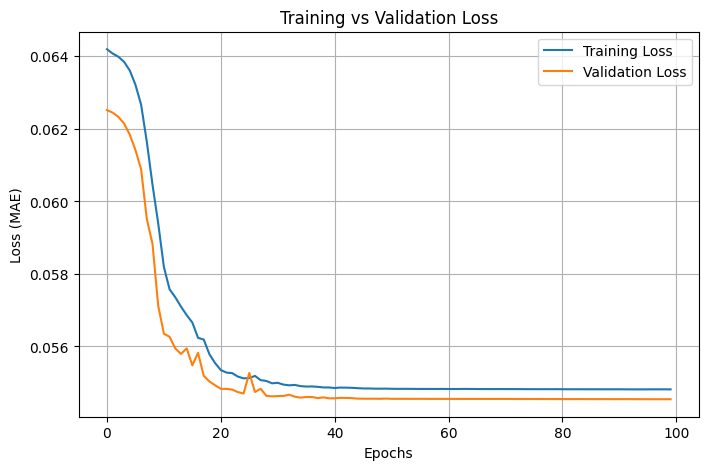

In [50]:
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (MAE)')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

# Threshold via Reconstruction Error (IQR)

We compute reconstruction error (MAE) on **validation-normal** samples and derive an anomaly band using the interquartile range (IQR).
Errors outside the band are flagged as anomalies.


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Anomaly detection threshold: Error < 0.0267 or > 0.0821


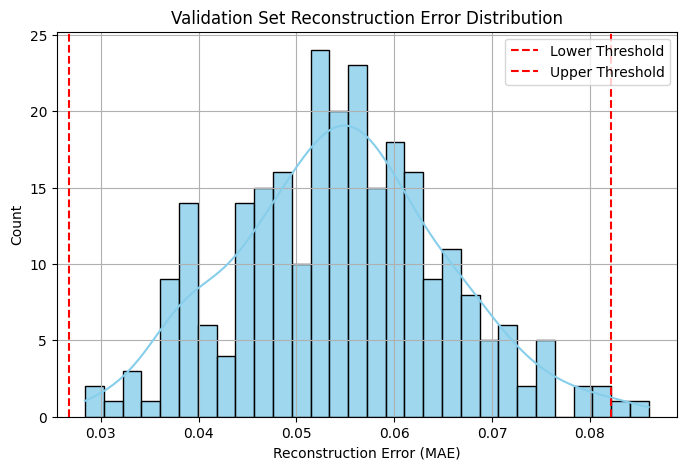

In [51]:
# Predict reconstructions on validation data
pred_valid = autoencoder.predict(X_valid_good)

#Calculate reconstruction errors (Mean Absolute Error)
recon_errors = tf.keras.losses.mae(X_valid_good, pred_valid).numpy()

# Calculate Interquartile Range (IQR) and thresholds
q1 = np.quantile(recon_errors, 0.25)
q3 = np.quantile(recon_errors, 0.75)
iqr = q3 - q1
lower_thresh = q1 - 1.5 * iqr
upper_thresh = q3 + 1.5 * iqr

print(f"Anomaly detection threshold: Error < {lower_thresh:.4f} or > {upper_thresh:.4f}")

#Plot distribution of reconstruction errors
plt.figure(figsize=(8,5))
sns.histplot(recon_errors, bins=30, kde=True, alpha=0.8, color='skyblue')
plt.axvline(lower_thresh, color='red', linestyle='--', label='Lower Threshold')
plt.axvline(upper_thresh, color='red', linestyle='--', label='Upper Threshold')
plt.xlabel('Reconstruction Error (MAE)')
plt.ylabel('Count')
plt.title('Validation Set Reconstruction Error Distribution')
plt.legend()
plt.grid(True)
plt.show()


# Validation Performance

In [52]:
# Build evaluation set (GOOD first, then BAD)
Xe = np.concatenate([X_valid_good, X_valid_bad], axis=0)
ye = np.concatenate([
    np.zeros(len(X_valid_good), dtype=int),  # 0 = normal (good)
    np.ones(len(X_valid_bad),  dtype=int)    # 1 = anomaly (bad)
])

# Predict reconstructions and compute MAE per sample
Xe_pred = autoencoder.predict(Xe, verbose=0)
errs = tf.keras.losses.mae(Xe, Xe_pred).numpy()

# Classify: outside the IQR band is anomaly
yhat = ((errs < lower_thresh) | (errs > upper_thresh)).astype(int)

# Report
print(confusion_matrix(ye, yhat))
print(classification_report(ye, yhat, target_names=["normal(good)", "anomaly(bad)"], digits=4))


[[261   2]
 [  7   5]]
              precision    recall  f1-score   support

normal(good)     0.9739    0.9924    0.9831       263
anomaly(bad)     0.7143    0.4167    0.5263        12

    accuracy                         0.9673       275
   macro avg     0.8441    0.7045    0.7547       275
weighted avg     0.9626    0.9673    0.9631       275

